In [2]:
from pathlib import Path
import sys
PROJ_NAME = "optimal-stopping"

# Locate the Project directory
curr_dir = str(Path.cwd())
start = curr_dir.find(PROJ_NAME)
if start < 0:
    print("ERROR: Project directory not found")
    print("Make sure you have the correct project structure")
    print("and run the simulation from within the project")
proj_pathname = curr_dir[:(start+len(PROJ_NAME))]

# Create path to the project directory
proj_path = Path(proj_pathname)

# Add the project folder to PATH
sys.path.append(proj_pathname)

In [10]:
from bin.data_import import data_init
from bin.data_import import import_dataset_1 as im
from bin.plot_d1 import *
from policies.policy import *
from bin.result import Result
from svr.svr_model import k_fold_cv as get_error
from svr.svr_model import get_svr_rbf_model as get_model

SIZE = 200
# Initialising data structure
data_init()
sensor_dataset = im().iloc[0:SIZE,:]
print(len(sensor_dataset))

200


In [11]:
W=25
S="R3"
theta = 0.3
B=4

def getNewX(data):
    return data[['Temp.','Humidity']].values

def getNewY(data, S):
    return data[[S]].values



In [12]:

data = sensor_dataset.iloc[0:W,:]

# Reshape the temperature and humidity values
init_X = getNewX(data)
# Reshape the sensor values
init_y = getNewY(data, S)
# Build a model to be sent to the Edge Gate
model = get_model(init_X, init_y)
# Evaluate the model
err = get_error(model, init_X, init_y)

err_diff = []
err_storage = [err]
init_err = err
init_model = model

comm_count = 1
comm = [comm_count]

err_sum = err

dataset_length = len(sensor_dataset)

i = 1
Vreward = 0
Vreward_vector = []
while (i + W) <= dataset_length:
    # Receive a new datapoint
    data = sensor_dataset.iloc[i:i+W,:]
    X = getNewX(data)
    y = getNewY(data, S)
    # Build a new model with the newly arrived datapoint 
    # and the discarded oldest datapoint
    new_model = get_model(X, y)
    # Evaluate
    new_err = get_error(new_model, X, y)
    err_storage += [new_err]

    init_model_err = get_error(init_model, X, y)
    err_diff += [abs(init_model_err-new_err)]

    err_sum += err_diff[-1]

    #DECIDE if we should update or not
    if err_sum <= theta:
        Vreward += 1
        Vreward_vector += [Vreward]
    else:
        Vreward = -B
        Vreward_vector += [Vreward]
        Vreward = 0
        init_model = new_model
        err_sum = new_err
        
    # Slide the window with 1
    i += 1


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, -4, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141]


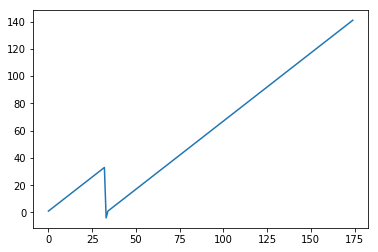

Expected value of M(essages): 2.9940119760479043


In [13]:
print(Vreward_vector)
plt.plot(Vreward_vector)
plt.show()
size_Vreward = len(Vreward_vector)
expReward = \
    sum([x*(Vreward_vector.count(x)/size_Vreward) for x in Vreward_vector])
expM = SIZE/expReward
print("Expected value of M(essages):",expM)

In [14]:
from scipy.stats import gamma
import numpy as np

mean = np.mean(err_diff)
var = np.var(err_diff)

shape = mean**2/var
scale = var/mean
print("shape, k",shape)
print("scale, theta", scale)

cdf = gamma.cdf(sorted(err_diff), shape, scale=scale)
pdf = gamma.pdf(sorted(err_diff), shape, scale=scale)

shape, k 0.40814771456627613
scale, theta 0.008224840460212173


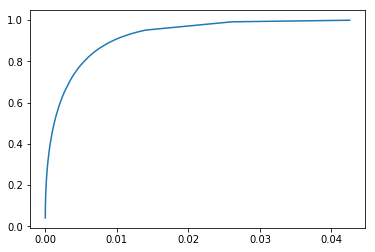

In [15]:
import matplotlib.pyplot as plt

x = sorted(gamma.rvs(shape, scale=scale, size = 100))
plt.plot(x,gamma.cdf(x, shape, scale=scale))
plt.show()

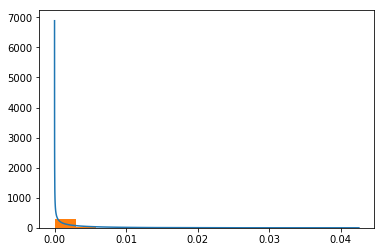

In [16]:
plt.plot(x,gamma.pdf(x, shape, scale=scale))
plt.hist(err_diff, density=True, bins=10)
plt.show()